# Kaggle competition for Assignment 1

### <span style="color:#0b486b"> II.0 Running on Google Colab</span> <span style="color:red"></span>
You will need to download relevant files to run this notebook on Google Colab.

In [1]:
!pip install --upgrade pip
!pip install gdown
!pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG
From (redirected): https://drive.google.com/uc?id=1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG&confirm=t&uuid=236a0b63-31fb-4fa9-ac98-442baaf50f9a
To: /kaggle/working/Animals_Dataset.zip
100%|█████████████████████████████████████████| 643M/643M [00:03<00:00, 183MB/s]


In [3]:
!unzip -oq Animals_Dataset.zip

In [4]:
# Commented out IPython magic to ensure Python compatibility.
import os
import requests
import tarfile
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import PIL.Image
import pathlib
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50, resnet101, densenet161, mobilenet_v3_large, efficientnet_b3, efficientnet_b4


# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA is not available.  Training on CPU ...


In [5]:
# Set seeds for reproducibility
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_all(1029)

# Initialize TensorBoard for advanced monitoring
writer = SummaryWriter('runs/experiment')

## Data Preprocess

In [6]:
data_dir = "./FIT5215_Dataset"

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image
    transforms.RandomHorizontalFlip(),  # Flip horizontally
    transforms.RandomRotation(5),  # Reduced rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Milder jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),  # Random Erasing with a 50% chance
])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Number of instances in train_set:", len(train_dataset))
print("Number of instances in val_set:", len(val_dataset))

Number of instances in train_set: 8519
Number of instances in val_set: 947


In [7]:
class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes', 'cats', 'chickens', 'cows', 'dogs', 'ducks',
                  'elephants', 'fishes', 'handguns', 'horses', 'lions', 'lipsticks', 'seals', 'snakes', 'spiders', 'vases']

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [9]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes', 'cats', 'chickens', 'cows', 'dogs', 'ducks',
                  'elephants', 'fishes', 'handguns', 'horses', 'lions', 'lipsticks', 'seals', 'snakes', 'spiders', 'vases']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

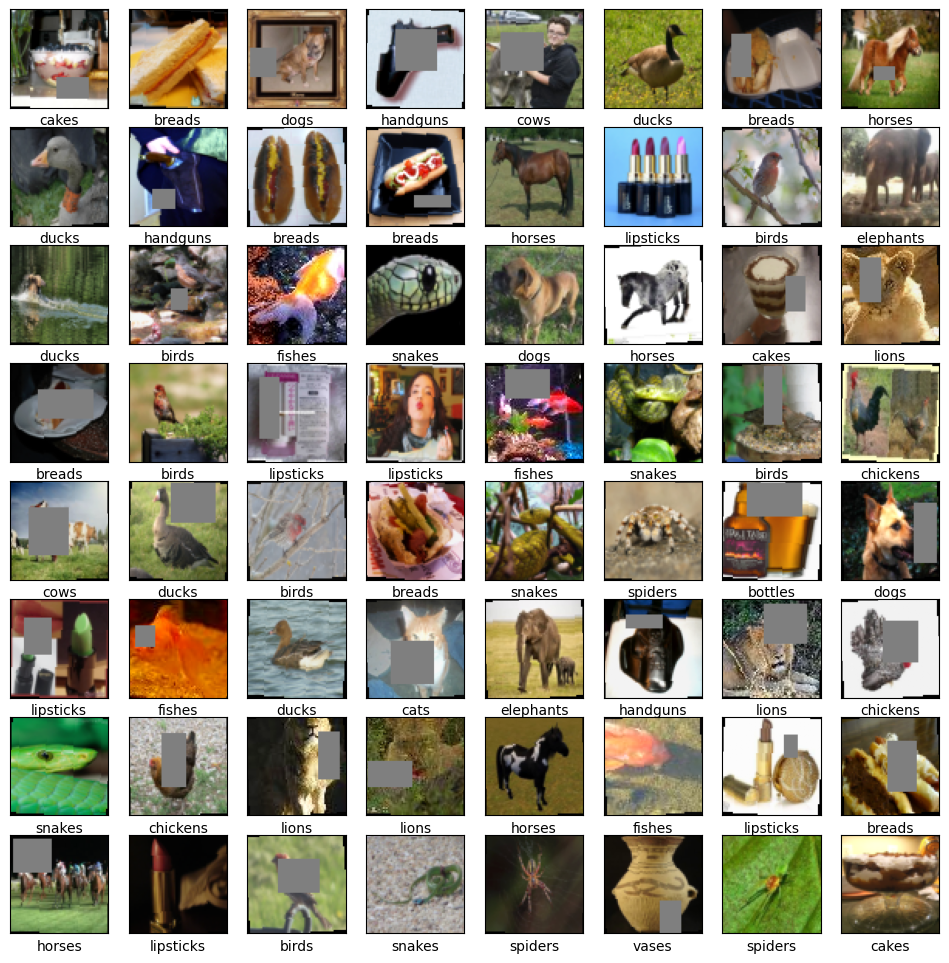

In [10]:
visualize_data(images, labels)

In [11]:
count_class = {}
for _,outs in dataset:
    labels = class_names[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1
count_class

{'birds': 512,
 'bottles': 432,
 'breads': 432,
 'butterflies': 500,
 'cakes': 432,
 'cats': 501,
 'chickens': 500,
 'cows': 500,
 'dogs': 501,
 'ducks': 496,
 'elephants': 500,
 'fishes': 500,
 'handguns': 448,
 'horses': 500,
 'lions': 500,
 'lipsticks': 400,
 'seals': 448,
 'snakes': 496,
 'spiders': 500,
 'vases': 368}

## Define Models

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Define custom Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, x, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(x)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * F.log_softmax(x, dim=-1), dim=-1))

# Initialize Label Smoothing Loss
loss_fn = LabelSmoothingLoss(classes=20, smoothing=0.05)

In [14]:
def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [15]:
def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

In [16]:
# Early Stopping Implementation
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize Early Stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

# Mix-Up Implementation
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Training Loop with the modified implementation
def fit(model=None, train_loader=None, valid_loader=None, optimizer=None, num_epochs=50, verbose=True):
    model.to(device)
    history = {'val_loss': [], 'val_acc': [], 'train_loss': [], 'train_acc': []}

    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        train_loss, train_correct = 0.0, 0
          # For GPU and CPU
        for (X, y) in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            loss.backward()

            # Gradient Clipping (optional)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update model parameters
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()

        # Calculate losses and accuracies for the epoch
        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Update the scheduler based on validation loss
        scheduler.step(val_loss)

        # Log data to TensorBoard (optional)
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        
        # Check for early stopping (if implemented)
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping at epoch:", epoch + 1)
            break

        end = time.time()
        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f} - Train acc: {train_acc*100:.2f}% - Val loss: {val_loss:.4f} - Val acc: {val_acc*100:.2f}% - Time: {end - start:.2f}s")

    writer.close()  # Close TensorBoard writer if used
    return history

## Training the Model

### Model Selection

In [17]:
# Models defined in code
# model = ResNet9().to(device)
# model = MiniVGG(20).to(device)
# model = CnnModel().to(device)



# Now, initialize the scheduler using the defined optimizer



# Define the model you want to use by uncommenting one of the following:
# Model 1: ResNet-50
# model = resnet50(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 20)  # Adjusting the final layer to match the number of classes (e.g., 20)

# Model 2: ResNet-101
# model = resnet101(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 20)  # Adjusting the final layer to match the number of classes (e.g., 20)

# Model 3: DenseNet-161
# model = densenet161(pretrained=True)
# model.classifier = nn.Linear(model.classifier.in_features, 20)  # Adjust final classifier to match number of classes

# Model 4: MobileNet V3 Large
# model = mobilenet_v3_large(pretrained=True)
# model.classifier[3] = nn.Linear(model.classifier[3].in_features, 20)  # Adjusting final layer for number of classes

# Model 5: EfficientNet-B3
# model = efficientnet_b3(pretrained=True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 20)  # Adjusting the final layer for number of classes

# # Model 6: EfficientNet-B4
# model = efficientnet_b4(pretrained=True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 20)  # Adjusting the final layer for number of classes

from torchvision.models import resnet50, ResNet50_Weights

# Load ResNet-50 with the recommended weights
weights = ResNet50_Weights.DEFAULT  # This uses the latest recommended weights
model = resnet50(weights=weights)

# Adjust the final fully connected layer to match the number of classes (e.g., 20)
model.fc = nn.Linear(model.fc.in_features, 20)

# Move the model to the device (GPU/CPU)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


#### <span style="color:#0b486b">4. Declaring the Loss, Optimizer, learning rate and Training the Model </span>

In [18]:
from torch import optim
optim_dict = {"Adam":optim.Adam, "Adadelta":optim.Adadelta, "Adagrad":optim.Adagrad,
              "Adamax":optim.Adamax, "AdamW": optim.AdamW, "ASGD":optim.ASGD,
              "NAdam":optim.NAdam, "RMSprop":optim.RMSprop, "RAdam":optim.RAdam,
              "Rprop": optim.Rprop, "SGD":optim.SGD}


# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4) # Directly imported from library

# Initialize the scheduler
# scheduler = StepLR(optimizer, step_size=15, gamma=0.5) # StepLR
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6) # ReduceLROnPlateau scheduler

#dnn_model = model
# Training and validation
history = fit(model=model, train_loader=train_loader, valid_loader=val_loader, optimizer=optimizer, num_epochs=50, verbose=True)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train loss: 0.0258 - Train acc: 57.33% - Val loss: 0.7136 - Val acc: 82.37% - Time: 355.91s
Epoch 2/50 - Train loss: 0.0095 - Train acc: 82.30% - Val loss: 0.4419 - Val acc: 87.01% - Time: 348.85s
Epoch 3/50 - Train loss: 0.0065 - Train acc: 87.24% - Val loss: 0.4025 - Val acc: 88.60% - Time: 349.89s
Epoch 4/50 - Train loss: 0.0050 - Train acc: 90.23% - Val loss: 0.3877 - Val acc: 90.18% - Time: 360.31s
Epoch 5/50 - Train loss: 0.0042 - Train acc: 91.92% - Val loss: 0.3269 - Val acc: 89.33% - Time: 346.65s
Epoch 6/50 - Train loss: 0.0034 - Train acc: 93.39% - Val loss: 0.3369 - Val acc: 89.55% - Time: 346.89s
Epoch 7/50 - Train loss: 0.0029 - Train acc: 94.19% - Val loss: 0.2993 - Val acc: 90.60% - Time: 356.18s
Epoch 8/50 - Train loss: 0.0025 - Train acc: 95.11% - Val loss: 0.2995 - Val acc: 91.02% - Time: 344.98s
Epoch 9/50 - Train loss: 0.0022 - Train acc: 95.63% - Val loss: 0.3061 - Val acc: 90.92% - Time: 340.19s
Epoch 10/50 - Train loss: 0.0018 - Train acc: 96.42% - 

#### <span style="color:#0b486b">5. Visualizing the Performance and Loss Objective Function </span>

There are four keys in the history dictionary: `train_loss` and `val_loss` measure the loss on the training set and the validation set, respectively, while `train_acc` and `val_acc` measure the accuracy on the training set and the validation set.  
The following figure visualize all four metrics with two y-axes, losses (blue lines, in descending) and accuracies (red lines, in asending)


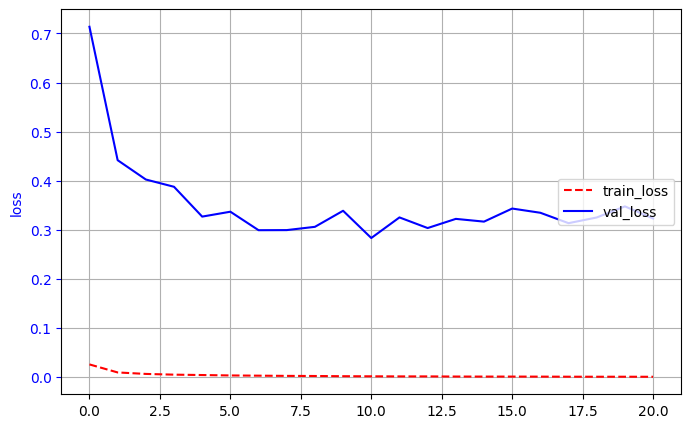

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'r--',label='train_loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

# Evaluate model on the testing set, get the csv file and upload to kaggle website.

In [20]:
!gdown --fuzzy https://drive.google.com/file/d/1gntVodsAzZntMb1qW2UCns-RdpckfQh0/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1gntVodsAzZntMb1qW2UCns-RdpckfQh0
From (redirected): https://drive.google.com/uc?id=1gntVodsAzZntMb1qW2UCns-RdpckfQh0&confirm=t&uuid=3fa51140-df01-42f1-900c-8fe901bd3491
To: /kaggle/working/test_set.zip
100%|███████████████████████████████████████| 28.9M/28.9M [00:00<00:00, 139MB/s]


In [21]:
!unzip -q test_set.zip

In [22]:
test_data_dir = "./test_set"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      #transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
testset = datasets.ImageFolder(test_data_dir, transform=transform)

print("Number of instance in test_set: %s" % len(testset))

test_loader = DataLoader(testset, batch_size=500, shuffle=False)


Number of instance in test_set: 16167


In [23]:
import torch
import pandas as pd

def save_prediction_to_csv(model, loader, device, output_file="submission.csv"):
    model.eval()
    predictions = []
    image_ids = []
    df = {
    "ID": [],
    "Label": []
    }
    total = 0
    with torch.no_grad():
        for i, (batchX, batchY) in enumerate(loader):
            batchX, batchY = batchX.to(device), batchY.to(device)
            outputs = model(batchX.float())  # Convert to float32 and feed batch to the model
            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class
            total += predicted.size(0)
            for ids, pred in enumerate(predicted):
                label = class_names[pred.to(device).item()]
                df["ID"].append(i*500+ids)
                df["Label"].append(label)
    df["ID"] = [i for i in range(total)]
    # Create a DataFrame
    df = pd.DataFrame(df)
    # Save to CSV
    df.to_csv(output_file, index=False)

In [24]:
save_prediction_to_csv(model, test_loader, device)

# Upload result to kaggle competition

## Regsiter Kaggle account using your private gmail
## Join the competition
## Upload the submission.csv file to the kaggle website to get your results